<a href="https://colab.research.google.com/github/abwahab175/Diabetic_Retinopathy/blob/main/brain_tumor_multi_class_segmentation_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This kernel is fork of [this](https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn#DataGenerator-and-Data-Augmentation) kernel.

### Steps:
+ Data Preparation
+ Visualization data
+ Datataset and DataGenerator
+ UNet
+ Train model
+ Test predictions

In [5]:
#https://www.kaggle.com/datasets/awsaf49/brain-tumor

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d awsaf49/brain-tumor

brain-tumor.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import zipfile
!zip_ref = zipfile.ZipFile('/content/brain-tumor.zip', 'r')
!zip_ref.extractall('/content/brain-tumor')
!zip_ref.close()

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `zip_ref = zipfile.ZipFile('/content/brain-tumor.zip', 'r')'
/bin/bash: -c: line 1: syntax error near unexpected token `'/content/brain-tumor''
/bin/bash: -c: line 1: `zip_ref.extractall('/content/brain-tumor')'
/bin/bash: -c: line 2: syntax error: unexpected end of file


# Data

In [9]:
! pip install albumentations

In [10]:
%%time

import numpy as np

images = np.load("/content/brain-tumor/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/brain-tumor/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/brain-tumor/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)
CPU times: user 27 ms, sys: 1.77 s, total: 1.8 s
Wall time: 2.44 s


Stacking rows as a data frame.

In [11]:
data = np.column_stack((images, masks, labels))
data.shape

(3064, 3)

Split data on train val test

In [12]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.08, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.12, random_state=42)

print("Train:", train_data.shape,
      "\nVal:", val_data.shape,
      "\nTest:", test_data.shape,)

Train: (2479, 3) 
Val: (246, 3) 
Test: (339, 3)


# What does the data look like?

### Class distribution

In [13]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

# https://www.kaggle.com/awsaf49/brain-tumor-visualization/data

labels, counts = np.unique(data[:,2], return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(labels, counts, color=["aqua", "violet", "greenyellow"],
        tick_label=['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'])


# Annotate
for row, value in zip(labels,counts):
    plt.annotate(int(value), xy=(row, value-150),
                rotation=0, color="black",
                ha="center", verticalalignment='bottom',
                fontsize=15, fontweight="bold")

Error in callback <function _draw_all_if_interactive at 0x7fc7895f5d80> (for post_execute):


TypeError: ignored

TypeError: ignored

<Figure size 1000x600 with 1 Axes>

### Samples of images of each class

In [14]:
import cv2

def data_to_viz(data, label, n=5):

    # logical slice for receiving data with the expected label
    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]

    # n random samples
    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]

    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:

        # img
        imgs.append(cv2.resize(data_i[0], (512, 512)))

        # mask
        masks.append(cv2.resize(data_i[1].astype("uint8"),
                                (512, 512)))

        # label
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

Data

In [15]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


Plot

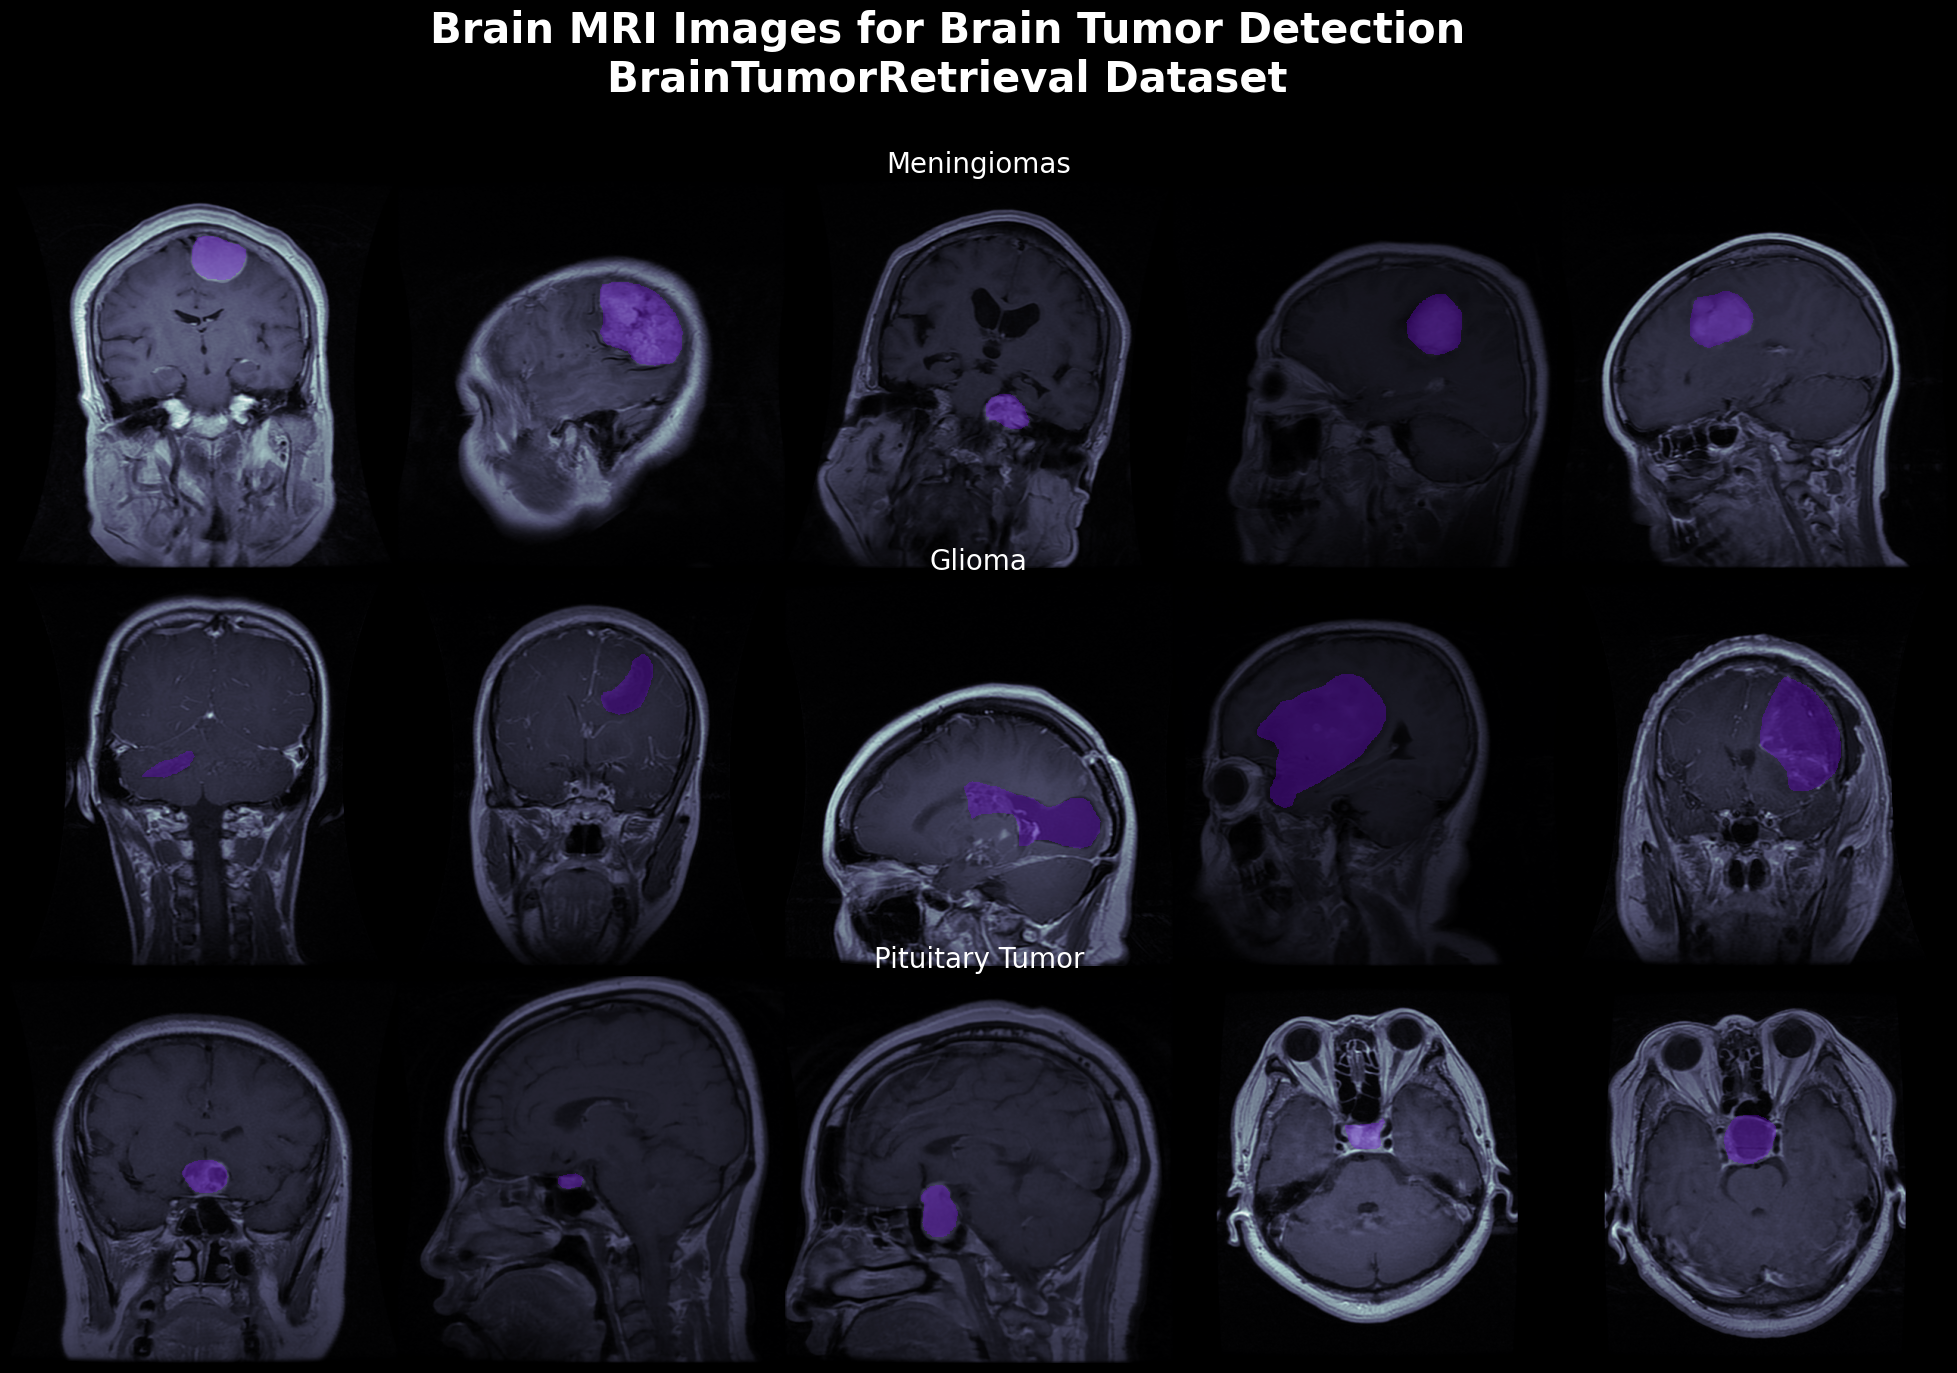

In [16]:
# Data to visualization
from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False,
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()

# Datataset and DataGenerator

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):

        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image = self.data[idx][0].astype("float32")

        # global standardization of pixels
        mean, std = image.mean(), image.std()
        image = (image - mean) / std

        # convert to rgb
        image_rgb = np.stack([image]*3).transpose(1,2,0)

        # create target masks
        label = self.data[idx][2] -1
        mask = np.expand_dims(self.data[idx][1], -1)

        target_mask = np.zeros((mask.shape[0], mask.shape[1],
                                self.n_classes))
        target_mask[:,:, label : label + 1] = mask.astype("uint8")

        #  binary mask
        target_mask = np.clip(target_mask, 0, 1).astype("float32")

        # augmentations
        augmented = self.transforms(image=image_rgb,
                                    mask=target_mask)
        image = augmented['image']
        mask = augmented['mask']

        return image, mask

### Data Transformation

In [19]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5,
                       border_mode=0),

    A.GridDistortion(p=0.5),
    A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    A.Resize(156, 156, p=1.),
    A.RandomCrop(128, 128, p=1.)
    ])

### Data Generators

In [20]:
# train
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4,
                              shuffle=True)

# validation
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4,
                            shuffle=True)

# test
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4,
                             shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([16, 128, 128, 3]) torch.Size([16, 128, 128, 3])


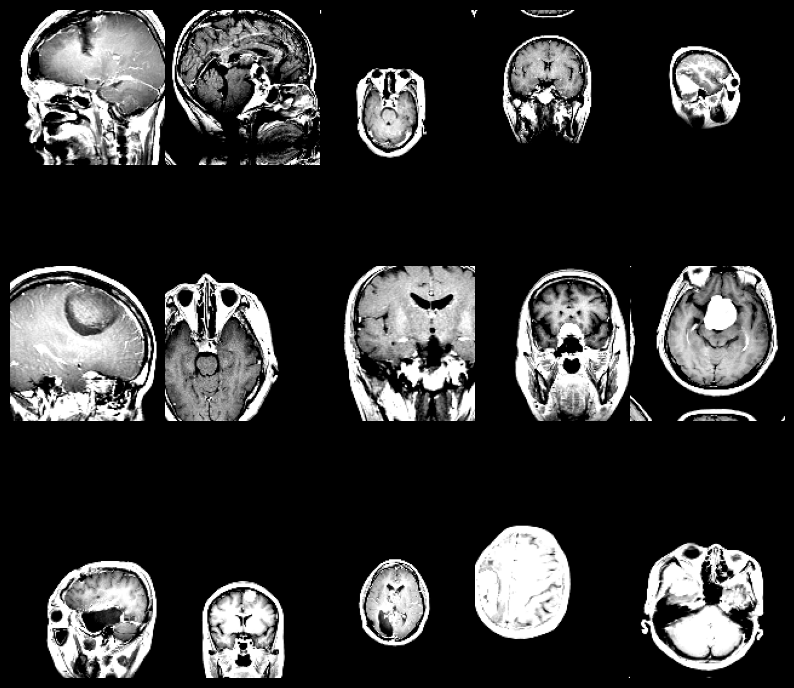

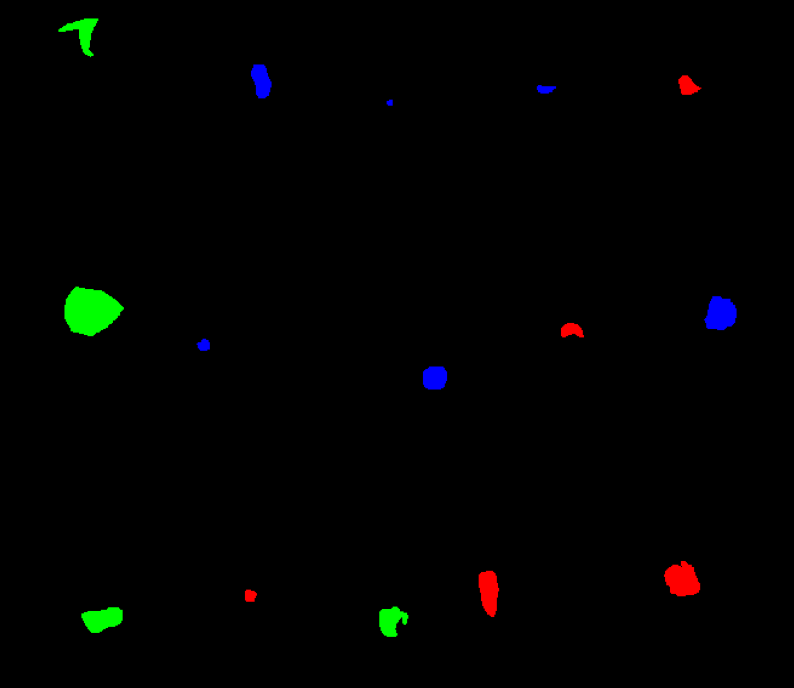

In [21]:
def show_aug(inputs, nrows=3, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 15:
        inputs = inputs[:15]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy()#.transpose(1,2,0)
            #mean = [0.485, 0.456, 0.406]
            #std = [0.229, 0.224, 0.225]
            #img = (img*std+mean).astype(np.float32)
            #img = np.clip(img, 0,1)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]

        #plot
        #print(img.max(), len(np.unique(img)), img.mean())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img);
        plt.axis('off')

        i_ += 1

    return plt.show()


images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks)


# UNet

In [22]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)

        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)

        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [23]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]

        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)


    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)

        return out


# Metric and Loss

In [24]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_coef_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [25]:
model = ResNeXtUNet(n_classes=3).to(device)
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 74.9MB/s]


# Train Model

In [26]:
def train_one_epoch(model, optimizer, lr_scheduler, data_loader, epoch):
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in data_loader:

        data = data.permute(0,3,1,2).to(device)
        targets = target.permute(0,3,1,2).to(device)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())

        loss = bce_dice_loss(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if lr_scheduler is not None:
        lr_scheduler.step()

    print("Epoch [%d]" % (epoch))
    print("Mean loss on train:", np.array(losses).mean(), "Mean DICE on train:", np.array(accur).mean())

    return np.array(losses).mean(), np.array(accur).mean()

In [27]:
def val_epoch(model, data_loader_valid, epoch, threshold=0.3):
    if epoch is None:
        print("Test Start...")
    else:
        print("Start Validation ...")

    model.eval()
    val_acc = []

    with torch.no_grad():
        for data, targets in data_loader_valid:

            data = data.permute(0,3,1,2).to(device)
            targets = targets.permute(0,3,1,2).to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())

        return np.array(val_acc).mean()

In [28]:
from tqdm import trange
import os
import glob

weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)

num_epochs = 30
loss_history = []
train_dice_history = []
val_dice_history = []

for epoch in trange(num_epochs):
    loss, train_dice = train_one_epoch(model, adam, scheduler,
                                       train_dataloader, epoch)

    val_dice = valscore = val_epoch(model, val_dataloader, epoch)

    # train history
    loss_history.append(loss)
    train_dice_history.append(train_dice)
    val_dice_history.append(val_dice)

    # save best weights
    best_dice = max(val_dice_history)
    if val_dice >= best_dice:
        torch.save({'state_dict': model.state_dict()},
                   os.path.join(weights_dir, f"{val_dice:0.5f}_.pth"))


  0%|          | 0/30 [00:00<?, ?it/s]

Start Train ...
Epoch [0]
Mean loss on train: 0.886799333941552 Mean DICE on train: 0.184642412810439
Start Validation ...
Epoch:  0  Threshold:  0.3 Mean Validation DICE Score: 0.36707016544869064


  3%|▎         | 1/30 [01:59<57:34, 119.12s/it]

Start Train ...
Epoch [1]
Mean loss on train: 0.653421575215555 Mean DICE on train: 0.42937379492338723
Start Validation ...
Epoch:  1  Threshold:  0.3 Mean Validation DICE Score: 0.5075660923929523


  7%|▋         | 2/30 [03:50<53:33, 114.77s/it]

Start Train ...
Epoch [2]
Mean loss on train: 0.5418132608936679 Mean DICE on train: 0.5298346114283524
Start Validation ...


 10%|█         | 3/30 [05:42<51:00, 113.36s/it]

Epoch:  2  Threshold:  0.3 Mean Validation DICE Score: 0.4732775810592882
Start Train ...
Epoch [3]
Mean loss on train: 0.5231159252505149 Mean DICE on train: 0.539822812130995
Start Validation ...
Epoch:  3  Threshold:  0.3 Mean Validation DICE Score: 0.591375595863419


 13%|█▎        | 4/30 [07:32<48:32, 112.01s/it]

Start Train ...
Epoch [4]
Mean loss on train: 0.4542978844335002 Mean DICE on train: 0.6032412582604584
Start Validation ...


 17%|█▋        | 5/30 [09:23<46:32, 111.69s/it]

Epoch:  4  Threshold:  0.3 Mean Validation DICE Score: 0.5452059680057229
Start Train ...
Epoch [5]
Mean loss on train: 0.4326591639749465 Mean DICE on train: 0.610967109720022
Start Validation ...


 20%|██        | 6/30 [11:14<44:31, 111.33s/it]

Epoch:  5  Threshold:  0.3 Mean Validation DICE Score: 0.5608457404832379
Start Train ...
Epoch [6]
Mean loss on train: 0.43357917474162194 Mean DICE on train: 0.6222031854118163
Start Validation ...


 23%|██▎       | 7/30 [13:05<42:42, 111.40s/it]

Epoch:  6  Threshold:  0.3 Mean Validation DICE Score: 0.5297665356333998
Start Train ...
Epoch [7]
Mean loss on train: 0.4301952088071454 Mean DICE on train: 0.6109086740258901
Start Validation ...


 27%|██▋       | 8/30 [14:57<40:53, 111.52s/it]

Epoch:  7  Threshold:  0.3 Mean Validation DICE Score: 0.5542222363940422
Start Train ...
Epoch [8]
Mean loss on train: 0.4347929496918955 Mean DICE on train: 0.6116058070899003
Start Validation ...
Epoch:  8  Threshold:  0.3 Mean Validation DICE Score: 0.627350147271686


 30%|███       | 9/30 [16:49<39:04, 111.63s/it]

Start Train ...
Epoch [9]
Mean loss on train: 0.4149980155691024 Mean DICE on train: 0.6309085567437054
Start Validation ...


 33%|███▎      | 10/30 [18:40<37:10, 111.52s/it]

Epoch:  9  Threshold:  0.3 Mean Validation DICE Score: 0.5170756231908596
Start Train ...
Epoch [10]
Mean loss on train: 0.3522921641026774 Mean DICE on train: 0.6842364323955046
Start Validation ...
Epoch:  10  Threshold:  0.3 Mean Validation DICE Score: 0.6891510457370182


 37%|███▋      | 11/30 [20:31<35:15, 111.32s/it]

Start Train ...
Epoch [11]
Mean loss on train: 0.3304498460023634 Mean DICE on train: 0.6973632773512389
Start Validation ...


 40%|████      | 12/30 [22:20<33:10, 110.57s/it]

Epoch:  11  Threshold:  0.3 Mean Validation DICE Score: 0.6386484139682118
Start Train ...
Epoch [12]
Mean loss on train: 0.31526487085127064 Mean DICE on train: 0.7160539624083909
Start Validation ...
Epoch:  12  Threshold:  0.3 Mean Validation DICE Score: 0.69841341358686


 43%|████▎     | 13/30 [24:09<31:13, 110.20s/it]

Start Train ...
Epoch [13]
Mean loss on train: 0.30975940352486026 Mean DICE on train: 0.7218728433142567
Start Validation ...


 47%|████▋     | 14/30 [25:57<29:12, 109.53s/it]

Epoch:  13  Threshold:  0.3 Mean Validation DICE Score: 0.6883241563888745
Start Train ...
Epoch [14]
Mean loss on train: 0.30407209377134997 Mean DICE on train: 0.728373204191563
Start Validation ...
Epoch:  14  Threshold:  0.3 Mean Validation DICE Score: 0.7184861325888625


 50%|█████     | 15/30 [27:46<27:20, 109.37s/it]

Start Train ...
Epoch [15]
Mean loss on train: 0.30280833763460957 Mean DICE on train: 0.7255720856448953
Start Validation ...


 53%|█████▎    | 16/30 [29:35<25:26, 109.06s/it]

Epoch:  15  Threshold:  0.3 Mean Validation DICE Score: 0.6828328516353337
Start Train ...
Epoch [16]
Mean loss on train: 0.29250390125859166 Mean DICE on train: 0.7390879592830042
Start Validation ...


 57%|█████▋    | 17/30 [31:23<23:34, 108.84s/it]

Epoch:  16  Threshold:  0.3 Mean Validation DICE Score: 0.7065329213650683
Start Train ...
Epoch [17]
Mean loss on train: 0.2963804212308699 Mean DICE on train: 0.736568501409434
Start Validation ...


 60%|██████    | 18/30 [33:11<21:45, 108.76s/it]

Epoch:  17  Threshold:  0.3 Mean Validation DICE Score: 0.6827179620048893
Start Train ...
Epoch [18]
Mean loss on train: 0.29094816542440843 Mean DICE on train: 0.7419892702902612
Start Validation ...
Epoch:  18  Threshold:  0.3 Mean Validation DICE Score: 0.720935473023733


 63%|██████▎   | 19/30 [35:01<19:57, 108.89s/it]

Start Train ...
Epoch [19]
Mean loss on train: 0.2828153274713024 Mean DICE on train: 0.7429455342393371
Start Validation ...
Epoch:  19  Threshold:  0.3 Mean Validation DICE Score: 0.7279038156242619


 67%|██████▋   | 20/30 [36:50<18:09, 108.97s/it]

Start Train ...
Epoch [20]
Mean loss on train: 0.2778857844491159 Mean DICE on train: 0.7437751582888913
Start Validation ...
Epoch:  20  Threshold:  0.3 Mean Validation DICE Score: 0.735433767293009


 70%|███████   | 21/30 [38:38<16:19, 108.87s/it]

Start Train ...
Epoch [21]
Mean loss on train: 0.281710436363374 Mean DICE on train: 0.7524044052539364
Start Validation ...


 73%|███████▎  | 22/30 [40:27<14:30, 108.85s/it]

Epoch:  21  Threshold:  0.3 Mean Validation DICE Score: 0.7170208316220126
Start Train ...
Epoch [22]
Mean loss on train: 0.2819758152769458 Mean DICE on train: 0.7485597760655139
Start Validation ...


 77%|███████▋  | 23/30 [42:16<12:41, 108.74s/it]

Epoch:  22  Threshold:  0.3 Mean Validation DICE Score: 0.7038297684970838
Start Train ...
Epoch [23]
Mean loss on train: 0.2730078258822041 Mean DICE on train: 0.7574859478321585
Start Validation ...


 80%|████████  | 24/30 [44:04<10:51, 108.51s/it]

Epoch:  23  Threshold:  0.3 Mean Validation DICE Score: 0.7261528890148418
Start Train ...
Epoch [24]
Mean loss on train: 0.2744817176653493 Mean DICE on train: 0.7535440005161826
Start Validation ...


 83%|████████▎ | 25/30 [45:51<09:01, 108.25s/it]

Epoch:  24  Threshold:  0.3 Mean Validation DICE Score: 0.7117937750565163
Start Train ...
Epoch [25]
Mean loss on train: 0.2768062949661286 Mean DICE on train: 0.7549982024033491
Start Validation ...


 87%|████████▋ | 26/30 [47:39<07:12, 108.06s/it]

Epoch:  25  Threshold:  0.3 Mean Validation DICE Score: 0.710199230795688
Start Train ...
Epoch [26]
Mean loss on train: 0.26742442658831994 Mean DICE on train: 0.7603783118176154
Start Validation ...


 90%|█████████ | 27/30 [49:26<05:23, 107.85s/it]

Epoch:  26  Threshold:  0.3 Mean Validation DICE Score: 0.7243257696426223
Start Train ...
Epoch [27]
Mean loss on train: 0.26380315769103263 Mean DICE on train: 0.7627292979720156
Start Validation ...


 93%|█████████▎| 28/30 [51:14<03:35, 107.78s/it]

Epoch:  27  Threshold:  0.3 Mean Validation DICE Score: 0.7204597044862417
Start Train ...
Epoch [28]
Mean loss on train: 0.27056743233434616 Mean DICE on train: 0.7576927752233615
Start Validation ...


 97%|█████████▋| 29/30 [53:02<01:47, 107.81s/it]

Epoch:  28  Threshold:  0.3 Mean Validation DICE Score: 0.7314749049188431
Start Train ...
Epoch [29]
Mean loss on train: 0.27113892484095786 Mean DICE on train: 0.7587965206162193
Start Validation ...


100%|██████████| 30/30 [54:49<00:00, 109.66s/it]

Epoch:  29  Threshold:  0.3 Mean Validation DICE Score: 0.7077062088893198


Since the net did not reach a plateau, batch norm layers did not accumulate stable statistics; therefore, saved model weights in the early steps of the train loop - shows worse results, how to fix it? reach a plateau or go forward several epochs with ```torch.no_grad_():``` (dirty tricks) before saving weights or before switching the model to eval mode ```model.eval()``` for the weights that are.

In [29]:
 # Dirty tricks
""" with torch.no_grad():
        for data, targets in data_loader_valid:
            data = data.permute(0,3,1,2).to(device)
            outputs = model(data)


model.eval()
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
     m.track_runing_stats=False""";

In [30]:
# Load the best weights
best_weights =  sorted(glob.glob(weights_dir + "/*"),
                       key= lambda x: x[8:-5])[-1]
checkpoint = torch.load(best_weights)
model.load_state_dict(checkpoint['state_dict'])

print(f'Loaded model: {best_weights.split("/")[1]}')

Loaded model: 0.73543_.pth


### Train history

In [31]:
def plot_model_history(train_history,
                       val_history,
                       loss_history ,
                       num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")
    plt.plot(x, loss_history, label='dice + bce', lw=3)

    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.legend()

    return plt.show()

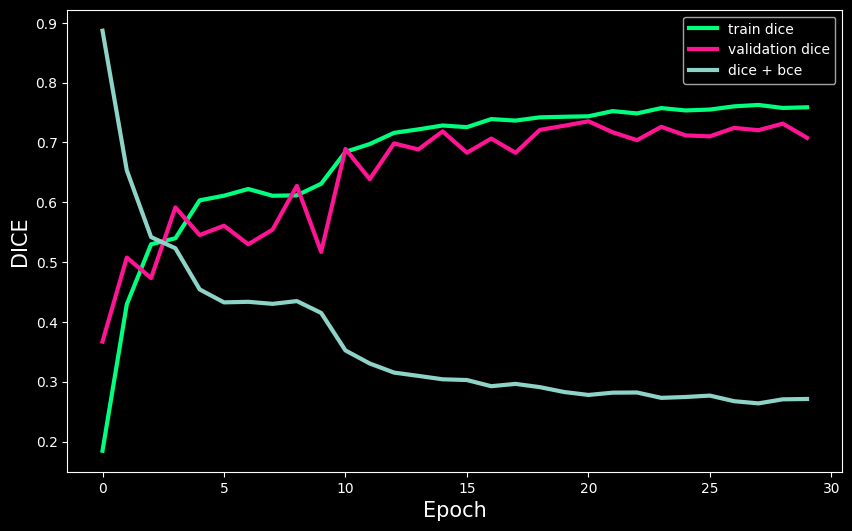

In [32]:
plot_model_history(train_dice_history, val_dice_history, loss_history, num_epochs)

# Test prediction

In [33]:
test_iou = val_epoch(model, test_dataloader, epoch=None, threshold=0.5)
print(f"""Mean IoU of the test images - {np.around(test_iou, 2)*100}%""")

Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.7230839226110644
Mean IoU of the test images - 72.0%


### Global IoU with different thresholds

In [34]:
dices = []
thresholds = [0.1, 0.2, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.88]
for i in thresholds:
    test_dice = val_epoch(model, test_dataloader,threshold=i, epoch=None)
    dices.append(test_dice)

Test Start...
Epoch:  None  Threshold:  0.1 Mean Validation DICE Score: 0.7228607082863377
Test Start...
Epoch:  None  Threshold:  0.2 Mean Validation DICE Score: 0.7335700905578147
Test Start...
Epoch:  None  Threshold:  0.33 Mean Validation DICE Score: 0.7479767381279832
Test Start...
Epoch:  None  Threshold:  0.4 Mean Validation DICE Score: 0.7276793449707767
Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.716830918376433
Test Start...
Epoch:  None  Threshold:  0.6 Mean Validation DICE Score: 0.7373314224137026
Test Start...
Epoch:  None  Threshold:  0.7 Mean Validation DICE Score: 0.748267558807319
Test Start...
Epoch:  None  Threshold:  0.8 Mean Validation DICE Score: 0.7399108019720132
Test Start...
Epoch:  None  Threshold:  0.85 Mean Validation DICE Score: 0.7539308655070961
Test Start...
Epoch:  None  Threshold:  0.88 Mean Validation DICE Score: 0.7138278326538177


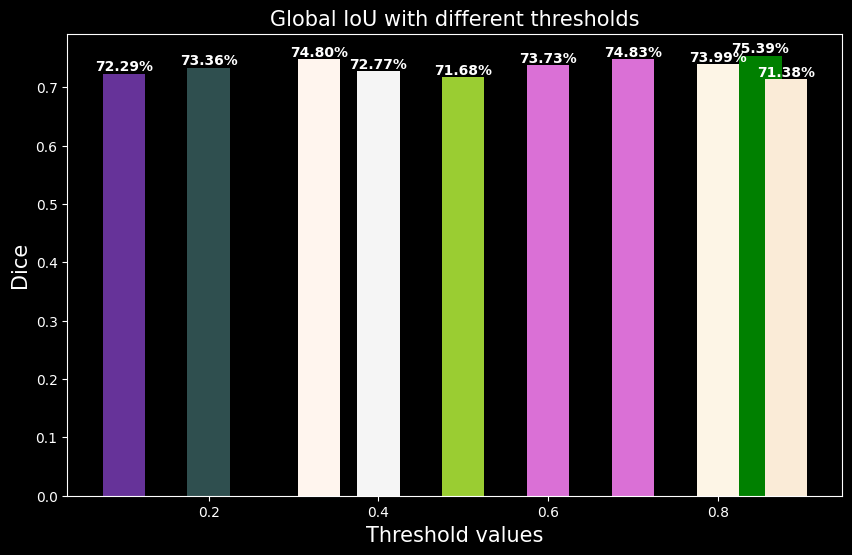

In [35]:
import random
import matplotlib.colors as mcolors

colors = random.choices(list(mcolors.CSS4_COLORS.keys()),k=len(thresholds))

plt.figure(figsize=(10,6))
plt.bar(thresholds, dices, width=0.05, color=colors)
plt.ylabel("Dice", fontsize=15)
plt.xlabel("Threshold values", fontsize=15)
plt.title("Global IoU with different thresholds", fontsize=15)


# Annotate
for row, value in zip(thresholds, dices):
    plt.annotate(f"{value*100:0.2f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")

### IoU for each class


In [36]:
test_predictions = []
test_ground_truths = []
for data, target in test_dataloader:
    with torch.no_grad():
        data = data.permute(0,3,1,2).to(device)
        target = target.permute(0,3,1,2)
        prediction = model(data)
        test_predictions.append(prediction.detach().cpu())
        test_ground_truths.append(target)

In [37]:
test_predictions = torch.cat(test_predictions)
test_ground_truths = torch.cat(test_ground_truths)
#test_predictions = test_predictions.reshape(test_predictions.shape[0], -1)
#test_ground_truths = test_ground_truths.reshape(test_ground_truths.shape[0], -1)

print(test_predictions.shape, test_ground_truths.shape)

torch.Size([339, 3, 128, 128]) torch.Size([339, 3, 128, 128])


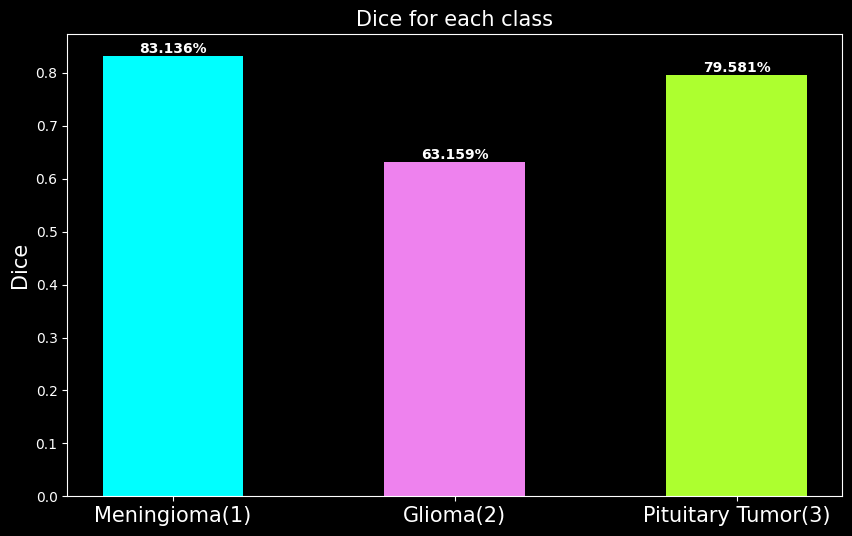

In [38]:
# data
dice1 = dice_coef_metric(test_predictions[:,0,:,:], test_ground_truths[:,0,:,:])
dice2 = dice_coef_metric(test_predictions[:,1,:,:], test_ground_truths[:,1,:,:])
dice3 = dice_coef_metric(test_predictions[:,2,:,:], test_ground_truths[:,2,:,:])
dices = [dice1, dice2, dice3]

# x, y
x = np.arange(3)
dices = [dice1, dice2, dice3]

# plot
plt.figure(figsize=(10, 6))
plt.bar(x, dices,
        color=["aqua", "violet", "greenyellow"], width=0.5)


plt.xticks(x, ['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'], fontsize=15)
plt.ylabel("Dice", fontsize=15)
plt.title("Dice for each class", fontsize=15)


# Annotate
for row, value in zip(x, dices):
    plt.annotate(f"{value*100:0.3f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")

plt.show()

### Random test sample

In [42]:
index = np.random.choice(test_data.shape[0], 1, replace=False)

# image
image = test_data[index][0][0]

# global standardization of pixels
mean, std = image.mean(), image.std()
image = (image - mean) / std
image = cv2.resize(image, (128, 128))
# convert to rgb
image = np.stack([image]*3).transpose(1,2,0)

# mask
mask = test_data[index][0][1]

# label
label = test_data[index][0][2]

print(image.shape, mask.shape, label)

(128, 128, 3) (512, 512) 3


Text(0.5, 1.0, 'Pituitary tumor')

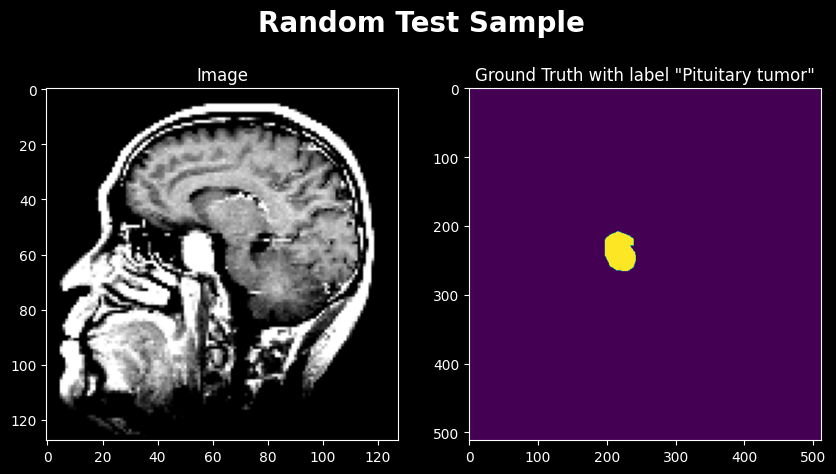

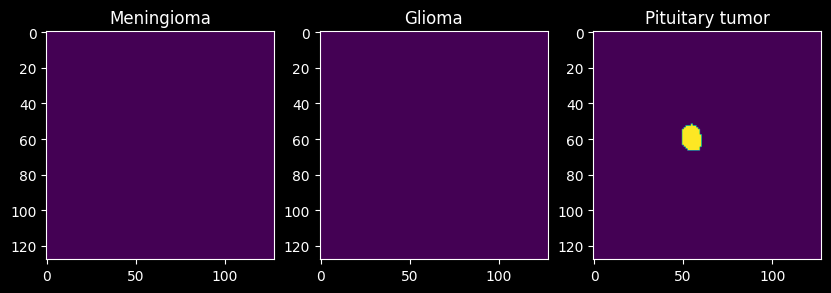

In [45]:
#----------- Data -------------#

# predictions
preds = torch.tensor(image.astype(np.float32)).unsqueeze(0).permute(0,3,1,2)
preds = model(preds.to(device))
preds = preds.detach().cpu().numpy()

# threshold
preds[np.nonzero(preds < 0.4)] = 0.0
preds[np.nonzero(preds >= 0.4)] = 255.#1.0
preds = preds.astype("uint8")

pred_1 = preds[:,0,:,:]
pred_2 = preds[:,1,:,:]
pred_3 = preds[:,2,:,:]


#------------ Plot ------------#

# data plot
fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(10, 10))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title(f'Ground Truth with label "{integer_to_class[label].capitalize()}"')
#ax[1].imshow(preds[0,:,:,:])
#ax[0].set_title("Preiction")
plt.suptitle("Random Test Sample",
             y=.75, fontsize=20, weight="bold")

# prediction plot
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))

ax[0].imshow(pred_1[0,:,:])
ax[0].set_title(f'{integer_to_class[1].capitalize()}')
ax[1].imshow(pred_2[0,:,:])
ax[1].set_title(f'{integer_to_class[2].capitalize()}')
ax[2].imshow(pred_3[0,:,:])
ax[2].set_title(f'{integer_to_class[3].capitalize()}')